<a href="https://colab.research.google.com/github/vijayshankarrealdeal/Kaggle/blob/main/R_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
# !wget 'http://nlp.stanford.edu/data/glove.6B.zip'
# !unzip "/content/glove.6B.zip" -d "/content/data/"
# !unzip "/content/train.csv.zip" -d "/content/data/"


In [10]:
import tensorflow as tf
import pandas as pd

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Bidirectional,GlobalMaxPooling1D,Dropout
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [12]:
MAX_SEQ_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
EPOCHS = 20
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2

In [13]:
word2vec = {}
with open('/content/data/glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec

In [14]:
train = pd.read_csv('/content/data/train.csv')
sentences = train['comment_text'].fillna("DUMMY_VALUES").values
possible_labels = ["toxic",'severe_toxic','obscene','threat','insult','identity_hate']
targets = train[possible_labels].values

In [15]:
def pre_process(sentences):
  tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
  tokenizer.fit_on_texts(sentences)
  sequences = tokenizer.texts_to_sequences(sentences)
  word2idx = tokenizer.word_index
  data = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)
  return data,word2idx
data,word2idx = pre_process(sentences)

In [16]:
num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
num_words,embedding_matrix.shape,EMBEDDING_DIM

(20000, (20000, 100), 100)

In [17]:
for word,i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [18]:
embedding_layer = tf.keras.layers.Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQ_LENGTH,
    trainable = False,
)

In [19]:
input_ = Input(shape = (MAX_SEQ_LENGTH))
x = embedding_layer(input_)
x = LSTM(15,return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
output = tf.keras.layers.Dense(len(possible_labels),activation = 'sigmoid')(x)
model = Model(input_,output)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate = 0.01),
    metrics = ['accuracy'],
)

In [20]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Epoch 1/20
998/998 [==============================] - 27s 20ms/step - loss: 0.0832 - accuracy: 0.9470 - val_loss: 0.0615 - val_accuracy: 0.9941
Epoch 2/20
998/998 [==============================] - 19s 19ms/step - loss: 0.0578 - accuracy: 0.9922 - val_loss: 0.0576 - val_accuracy: 0.9916
Epoch 3/20
998/998 [==============================] - 19s 19ms/step - loss: 0.0551 - accuracy: 0.9871 - val_loss: 0.0561 - val_accuracy: 0.9918
Epoch 4/20
998/998 [==============================] - 19s 19ms/step - loss: 0.0529 - accuracy: 0.9873 - val_loss: 0.0536 - val_accuracy: 0.9792
Epoch 5/20
998/998 [==============================] - 19s 19ms/step - loss: 0.0510 - accuracy: 0.9821 - val_loss: 0.0526 - val_accuracy: 0.9686
Epoch 6/20
998/998 [==============================] - 19s 19ms/step - loss: 0.0500 - accuracy: 0.9776 - val_loss: 0.0531 - val_accuracy: 0.9862
Epoch 7/20
998/998 [==============================] - 19s 19ms/step - loss: 0.0492 - accuracy: 0.9694 - val_loss: 0.0527 - val_accuracy:

[]

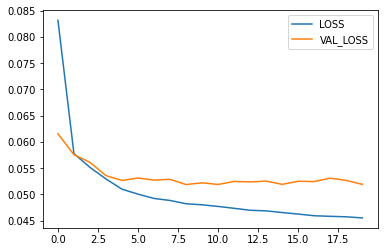

In [21]:
plt.plot(r.history['loss'],label = 'LOSS')
plt.plot(r.history['val_loss'],label = 'VAL_LOSS')
plt.legend()
plt.plot()

[]

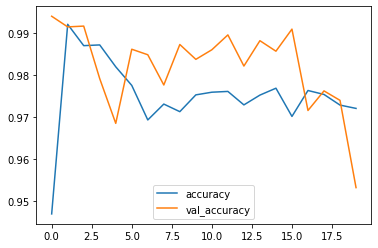

In [22]:
plt.plot(r.history['accuracy'],label = 'accuracy')
plt.plot(r.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
plt.plot()

In [23]:
predict = model.predict(data)

In [24]:
accs = []
for j in range(6):
  acu = roc_auc_score(targets[:,j],predict[:,j])
  accs.append(acu)
print(np.mean(accs)*100)

98.38622548784001


In [25]:
!unzip '/content/test.csv.zip' -d '/content/data/'

Archive:  /content/test.csv.zip
  inflating: /content/data/test.csv  


In [35]:
!unzip '/content/sample_submission.csv.zip' -d '/content/data/'

Archive:  /content/sample_submission.csv.zip
  inflating: /content/data/sample_submission.csv  


In [56]:
data_test = pd.read_csv('/content/data/test.csv')

In [57]:
ids  = data_test.id

In [58]:
data_test.drop('id',axis = 1,inplace = True)

In [59]:
ids

0         00001cee341fdb12
1         0000247867823ef7
2         00013b17ad220c46
3         00017563c3f7919a
4         00017695ad8997eb
                ...       
153159    fffcd0960ee309b5
153160    fffd7a9a6eb32c16
153161    fffda9e8d6fafa9e
153162    fffe8f1340a79fc2
153163    ffffce3fb183ee80
Name: id, Length: 153164, dtype: object

In [60]:
ids_ = pd.DataFrame(ids.values,columns=['id'])

In [61]:
sentences_test = data_test['comment_text'].fillna("DUMMY_VALUES").values
data_test,word2idx_test = pre_process(sentences_test)

In [62]:
predict_test = model.predict(data_test)

In [63]:
sub = pd.DataFrame(np.round(predict_test),columns=possible_labels)

In [64]:
sub

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
153159,1.0,0.0,0.0,0.0,1.0,0.0
153160,0.0,0.0,0.0,0.0,0.0,0.0
153161,0.0,0.0,0.0,0.0,0.0,0.0
153162,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
ids_

,id
0,00001cee341fdb12
1,0000247867823ef7
2,00013b17ad220c46
3,00017563c3f7919a
4,00017695ad8997eb
...,...
153159,fffcd0960ee309b5
153160,fffd7a9a6eb32c16
153161,fffda9e8d6fafa9e
153162,fffe8f1340a79fc2


In [67]:
finals = ids_.join(sub)
finals.to_csv("submission.csv", index=False)